In [80]:
%load_ext autoreload
%autoreload 2

# Pagel's lambda for growth rates
import os 
import matplotlib
from src.ihmp import get_diffs, pagels_dataframe

# Global variables
GG_TREE = "./greengenes/data/gg_13_5_otus_99_annotated.tree"
TOP_N = 1000
ABUNDANCE = True
FIG = {
    "dpi": 300,
    "figsize": (8.5, 5.5),
    "tight_layout": True,
}

# Set larger font size
matplotlib.rcParams.update({"font.size": 14})

# Datasets
names = ["ibd", "moms", "t2d"]

# Some string stuff
if ABUNDANCE:
    ab_str = "abun_"
    ab_title = "Relative abundances"
else:
    ab_str = ""
    ab_title = "Growth rates"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
# Distill into iHMP-agnostic function:
data = {
    name: get_diffs(name, top_n=TOP_N, get_abundances=ABUNDANCE)
    for name in names
}


In [82]:
# Compute lambda values for each iHMP dataset:

for name in names:
    outpath = f"./results/{name}_{ab_str}pls_top{TOP_N}.tsv"
    print(outpath)
    if os.path.exists(outpath):
        print(f"Skipping {outpath} because it already exists.")
        continue
    pls, tree = pagels_dataframe(data[name], GG_TREE)
    pls.to_csv(outpath, sep="\t")
    tree.write(
        format=1, outfile=f"./results/{name}_{ab_str}tree_top{TOP_N}.nwk"
    )


./results/ibd_abun_pls_top1000.tsv
Skipping ./results/ibd_abun_pls_top1000.tsv because it already exists.
./results/moms_abun_pls_top1000.tsv
Skipping ./results/moms_abun_pls_top1000.tsv because it already exists.
./results/t2d_abun_pls_top1000.tsv
Skipping ./results/t2d_abun_pls_top1000.tsv because it already exists.


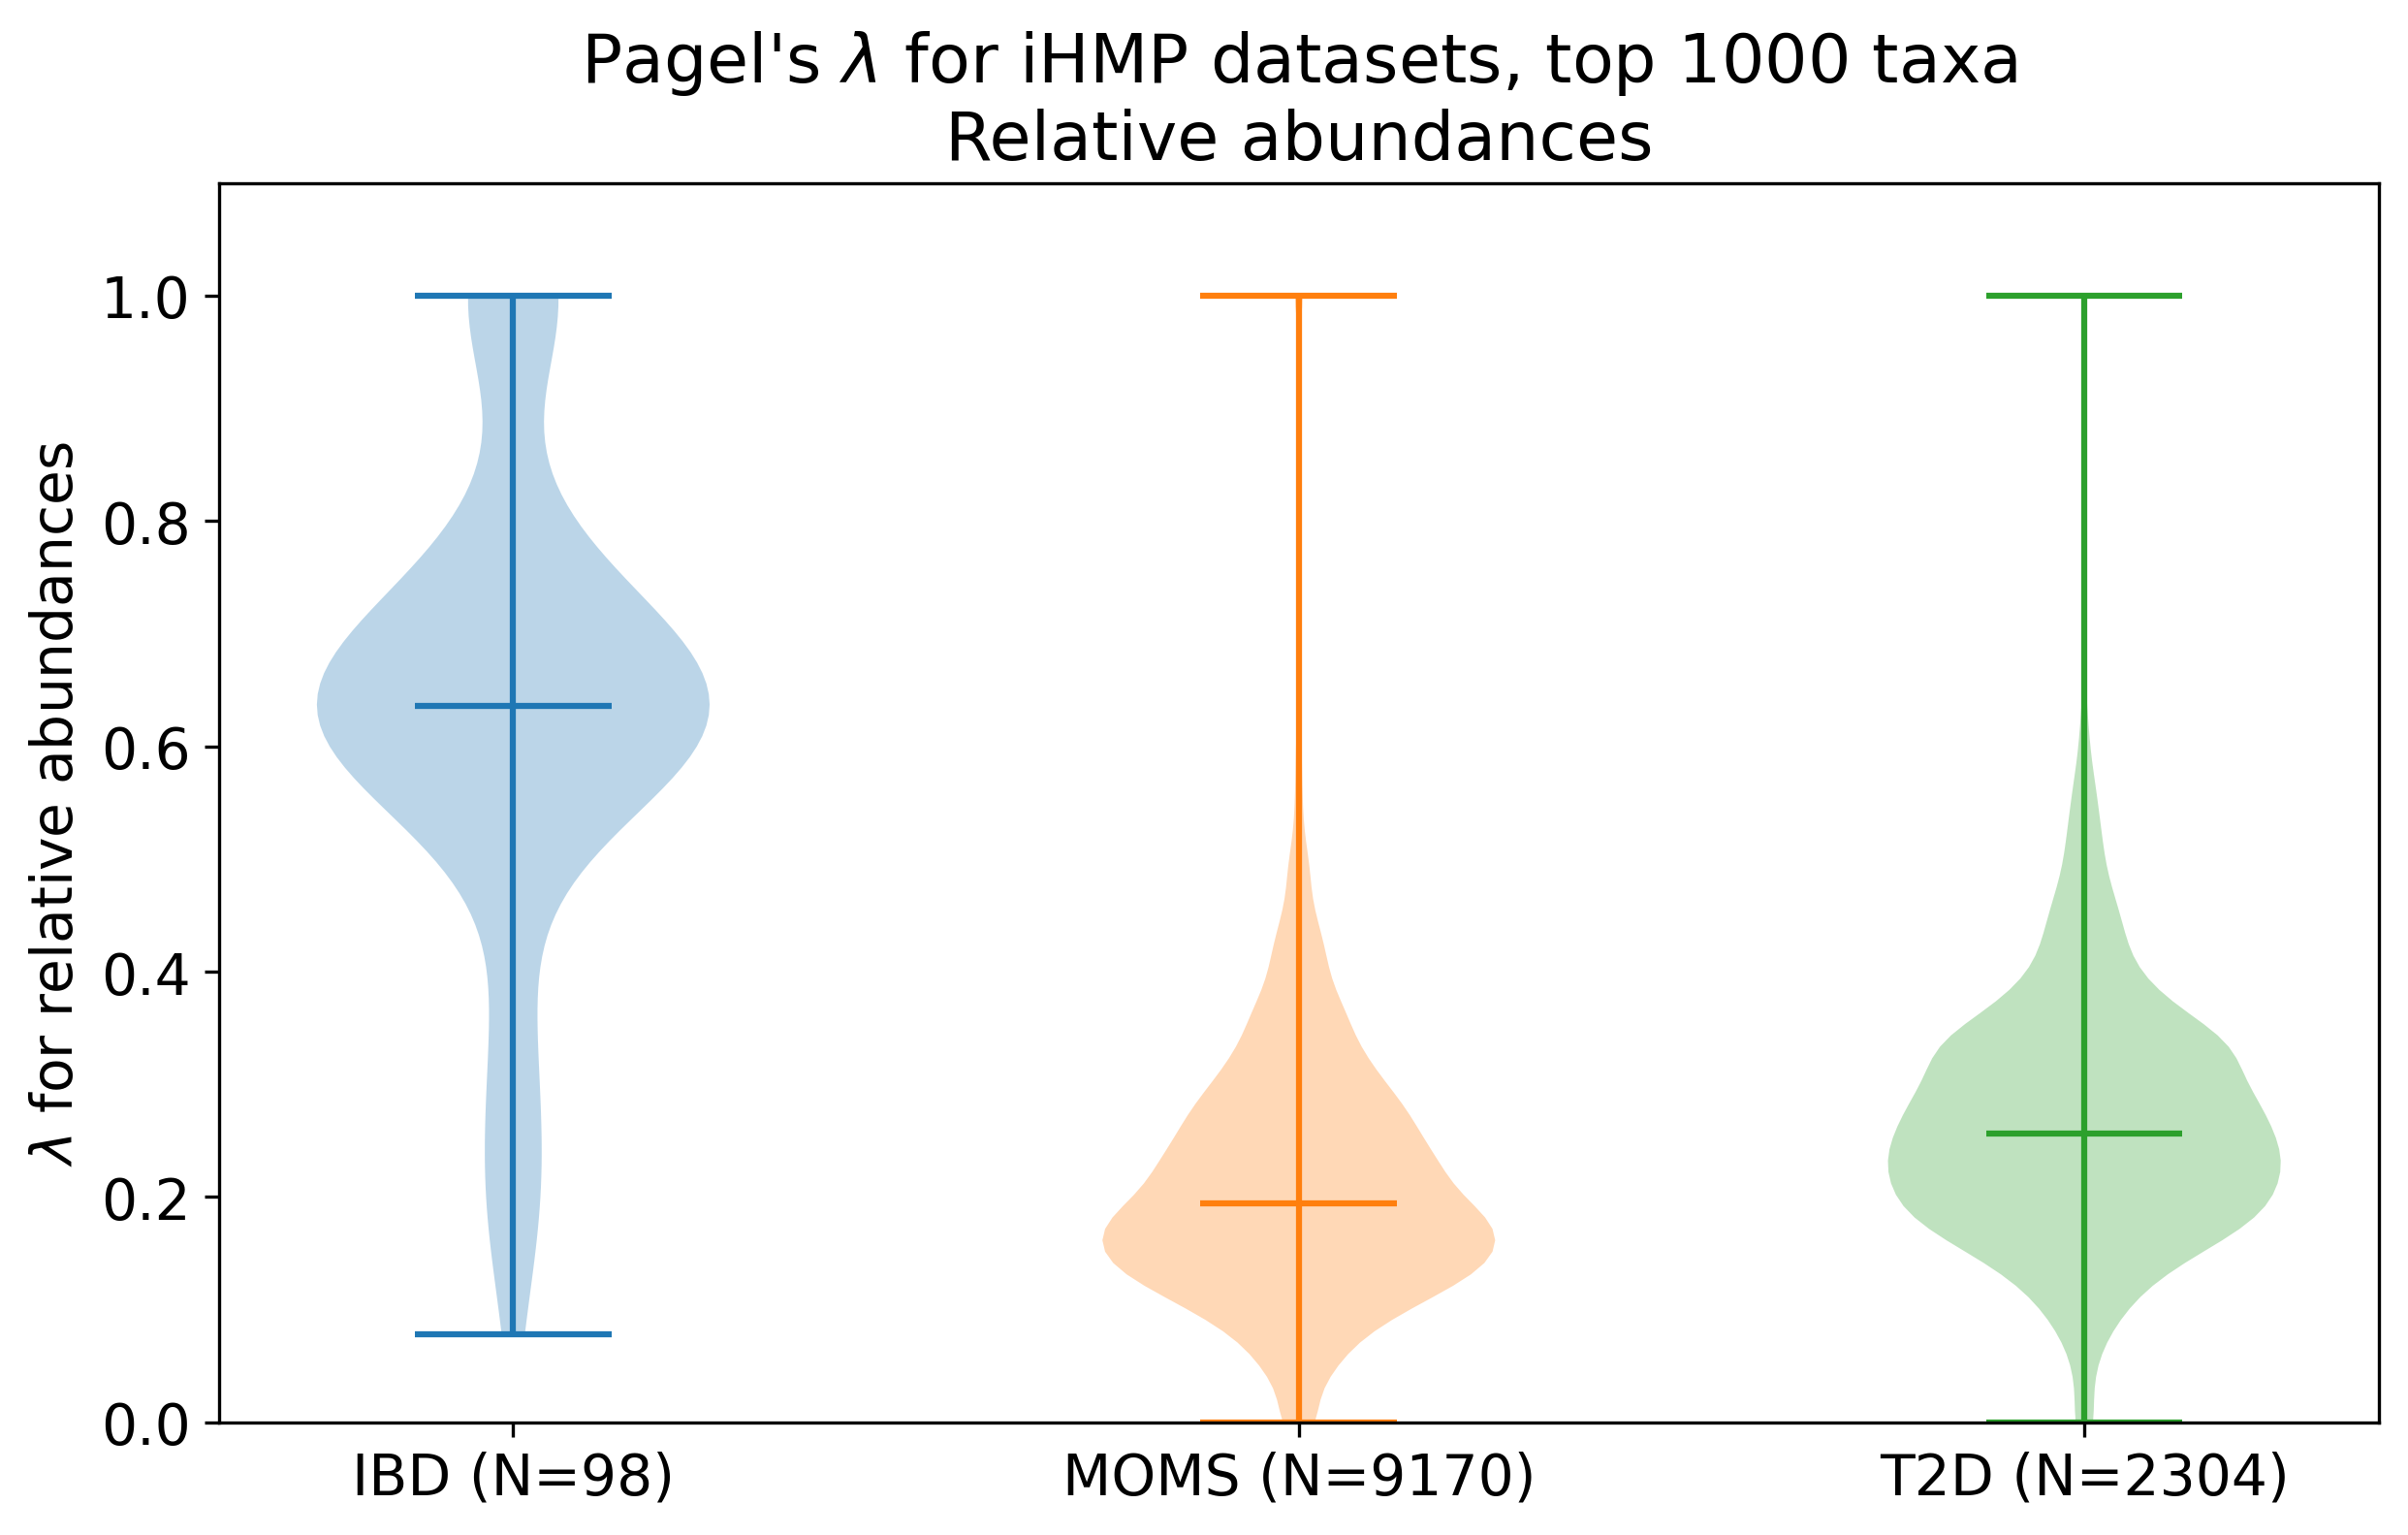

In [83]:
# Violin plot
import matplotlib.pyplot as plt
import pandas as pd

data = []
for name in names:
    pls = pd.read_table(f"./results/{name}_{ab_str}pls_top{TOP_N}.tsv")
    pls["dataset"] = name.upper()
    data.append(pls)

pls = pd.concat(data)

# Plot
plt.figure(**FIG)
labels = []
datasets = pls["dataset"].unique()
for i, dataset in enumerate(data):
    plt.violinplot(
        dataset["lambda"].dropna().values,
        showmedians=True,
        positions=[i + 1],
    )
    labels.append(f"{dataset['dataset'][0]} (N={len(dataset)})")

# print(len(ibd_pls["lambda"].dropna().values)) # 69
# print(len(moms_pls["lambda"].dropna().values)) # 6765
# print(len(t2d_pls["lambda"].dropna().values)) # 2071

plt.ylabel(f"$\lambda$ for {ab_title.lower()}")
plt.xticks(range(1, 4), labels)
# if ABUNDANCE:
#     plt.xticks(range(1, 4), ["IBD (N=98)", "MOMS-PI (N=9170)", "T2D (N=2304)"])
# else:
#     plt.xticks(range(1, 4), ["IBD (N=69)", "MOMS-PI (N=6765)", "T2D (N=2071)"])
plt.title(f"Pagel's $\lambda$ for iHMP datasets, top {TOP_N} taxa\n{ab_title}")
plt.ylim(0, 1.1)
plt.savefig(f"./results/{ab_str}pls_top{TOP_N}.png", dpi=300)
plt.show()

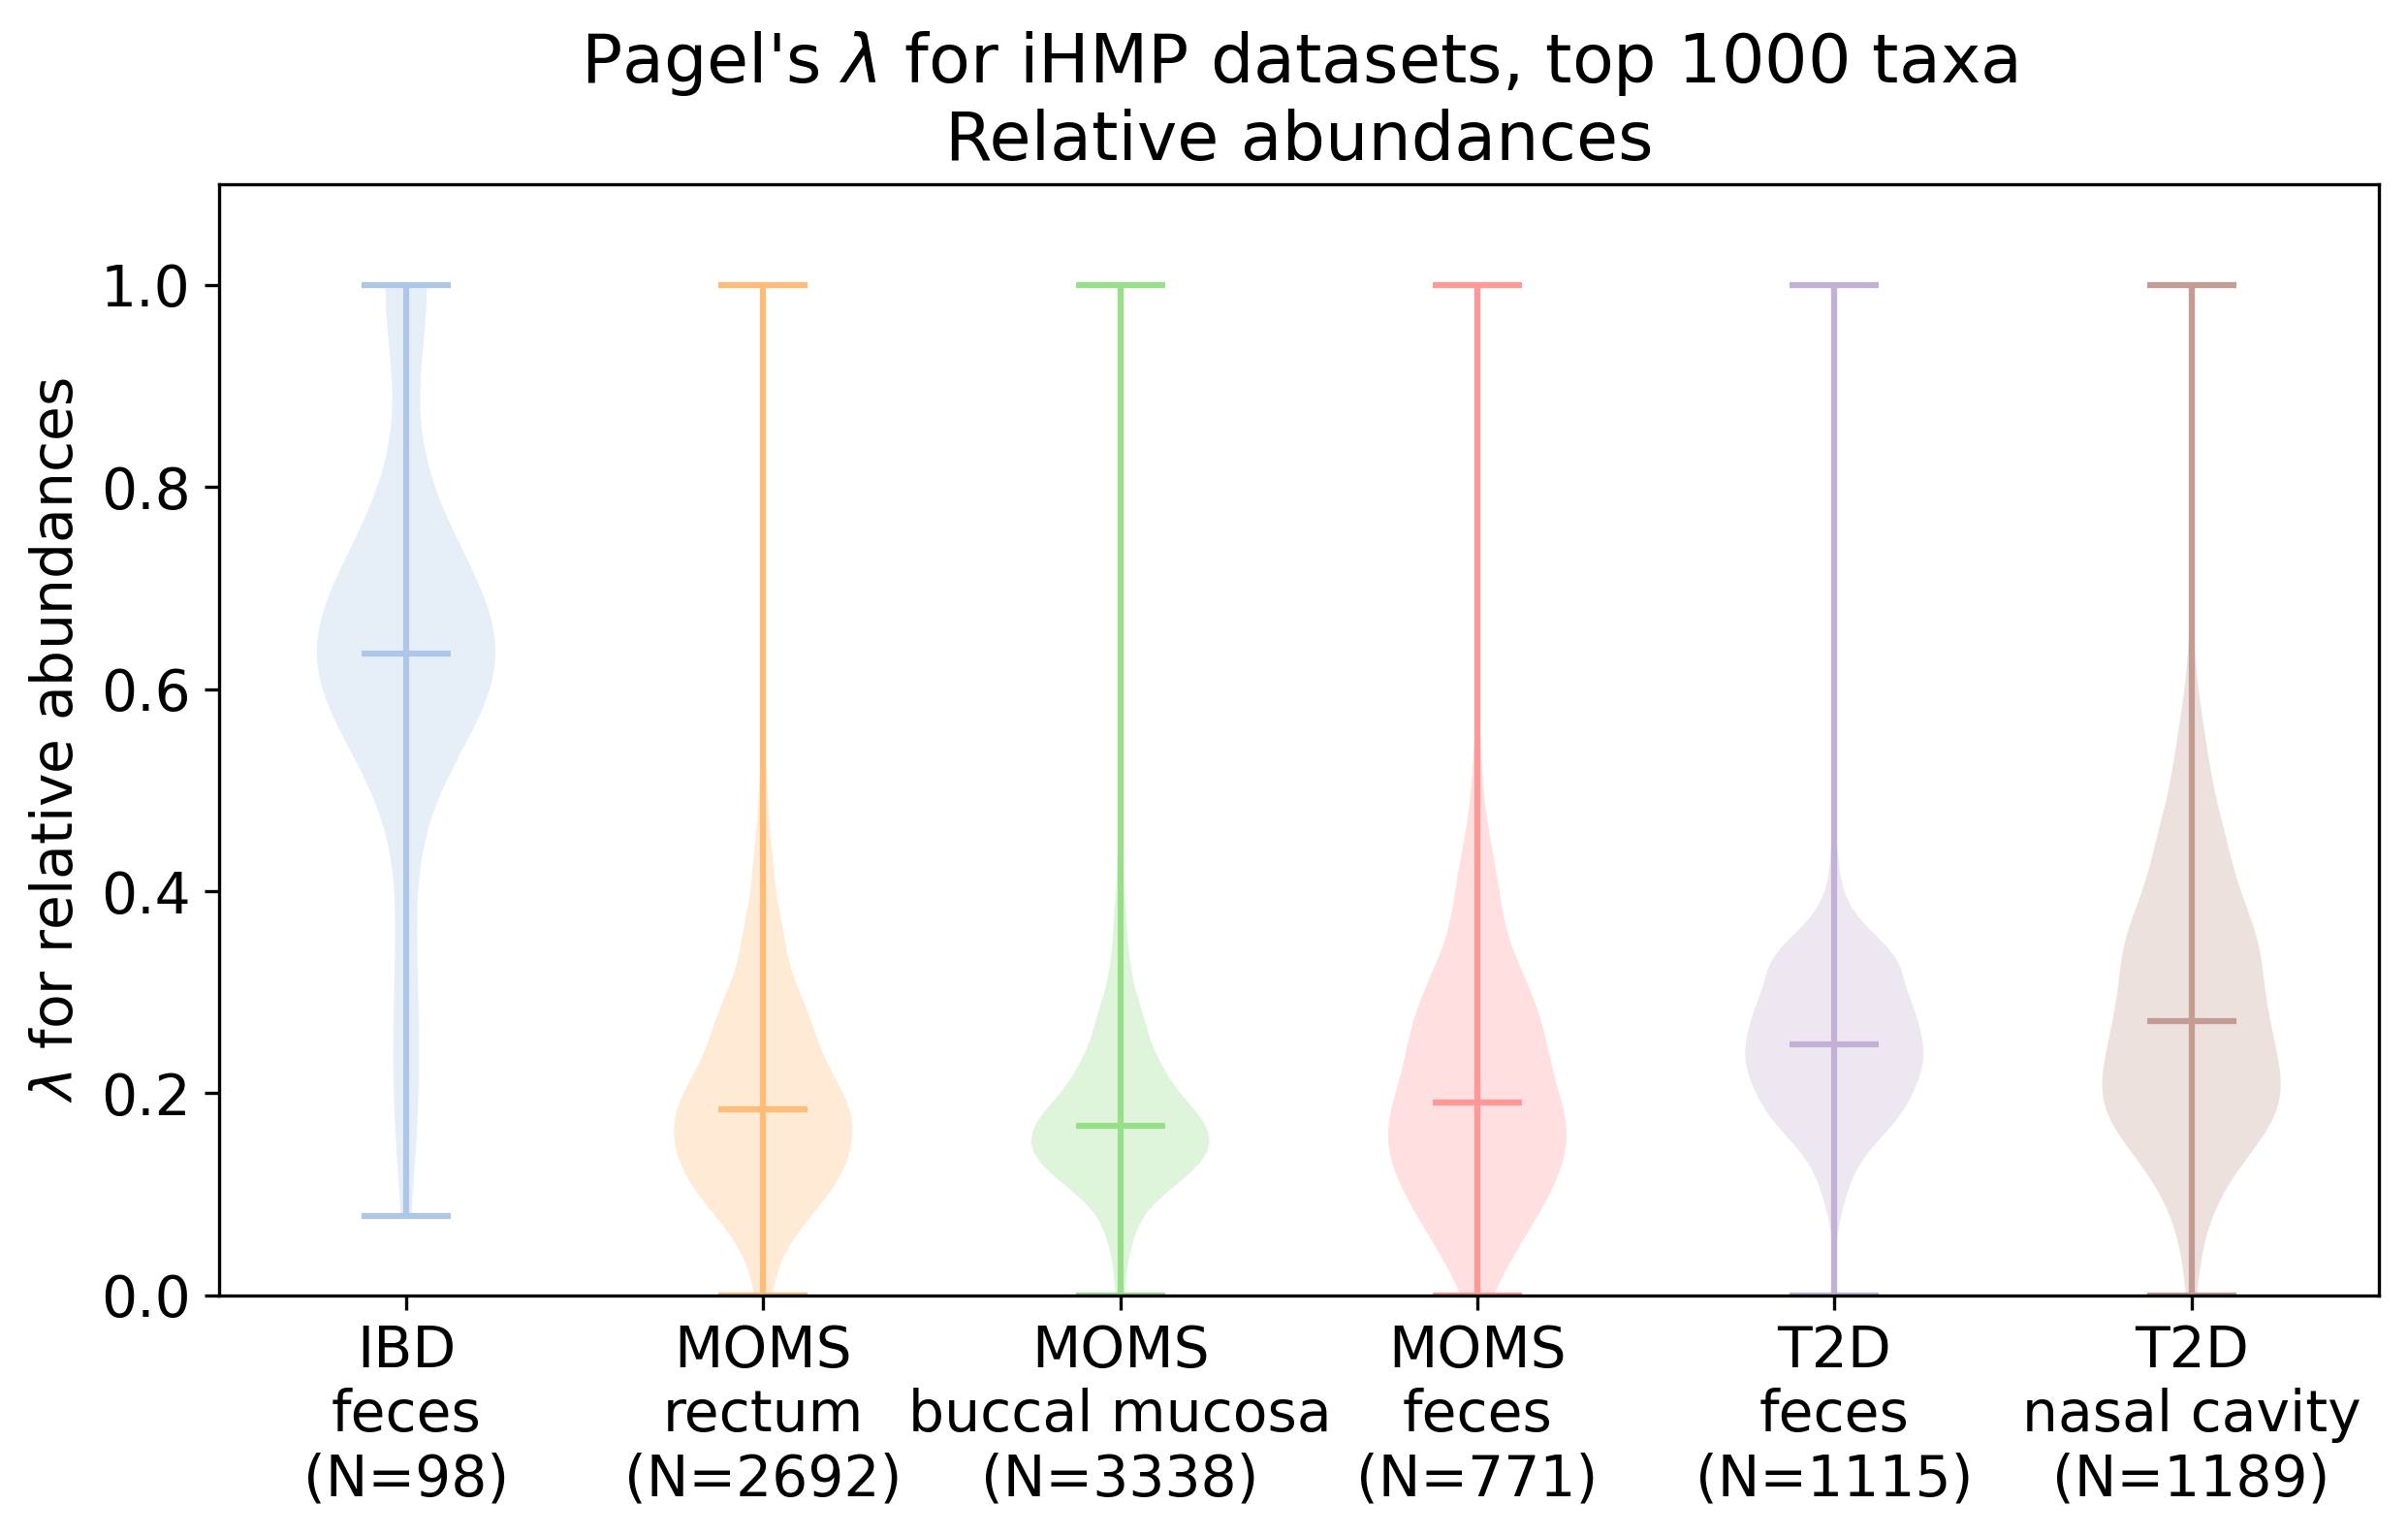

In [84]:
# Same thing but grouped by body site

# Get tab20 colors, then split into light and dark
cmap = matplotlib.cm.get_cmap("tab20", 20) # looks best with 20
tab20_dark = list(cmap.colors[::2])
tab20_light = list(cmap.colors[1::2])

# Only need the plotting part, though:
plt.figure(**FIG)
datasets = pls["dataset"].unique()
labels = []
position = 1
for dataset in data:
    for site in dataset["site"].unique():
        if site in ["vagina", "cervix of uterus", "unknown"]:
            continue # to match growth rate plot
        name = dataset["dataset"].unique()[0]
        lambdas = dataset[dataset["site"] == site]["lambda"].dropna().values

        if len(lambdas) > 4: # Drop uselessly small samples
            labels.append(f"{name}\n{site}\n(N={len(lambdas)})")
            ax = plt.violinplot(lambdas, showmedians=True, positions=[position])
            position += 1

            if ABUNDANCE:
                c = tab20_light.pop(0)
            else:
                c = tab20_dark.pop(0)
            
            for partname in ["cbars", "cmins", "cmaxes", "cmedians"]:
                ax[partname].set_edgecolor(c)
            ax["bodies"][0].set_facecolor(c)

plt.xticks(range(1, position), labels)
plt.ylabel(f"$\lambda$ for {ab_title.lower()}")
plt.title(f"Pagel's $\lambda$ for iHMP datasets, top {TOP_N} taxa\n{ab_title}")
plt.ylim(0, 1.1)
plt.savefig(f"./results/{ab_str}lambda_by_site_top{TOP_N}.png", dpi=300)
plt.show()

In [85]:
for x in tab20_dark:
    print(x)

[0.12156863 0.46666667 0.70588235 1.        ]
[1.         0.49803922 0.05490196 1.        ]
[0.17254902 0.62745098 0.17254902 1.        ]
[0.83921569 0.15294118 0.15686275 1.        ]
[0.58039216 0.40392157 0.74117647 1.        ]
[0.54901961 0.3372549  0.29411765 1.        ]
[0.89019608 0.46666667 0.76078431 1.        ]
[0.49803922 0.49803922 0.49803922 1.        ]
[0.7372549  0.74117647 0.13333333 1.        ]
[0.09019608 0.74509804 0.81176471 1.        ]


In [86]:
# New experiment: effect of top_N on lambda values, violin plot, IBD only

topn_vals = [10, 20, 50, 100, 200, 500, 1000]#, None]

for top_n in topn_vals:
    # We already did 100 and 1000, so we skip them for now
    outpath = f"./results/ibd_{ab_str}pls_top{top_n}.tsv"
    if os.path.exists(outpath):
        continue
    
    print(f"top_n={top_n}")
    diffs_ibd = get_diffs("ibd", top_n=top_n, get_abundances=ABUNDANCE)
    pls, tree = pagels_dataframe(diffs_ibd, GG_TREE)
    pls.to_table(outpath)
    tree.write(format=1, outfile=f"./results/ibd_{ab_str}tree_top{top_n}.nwk")

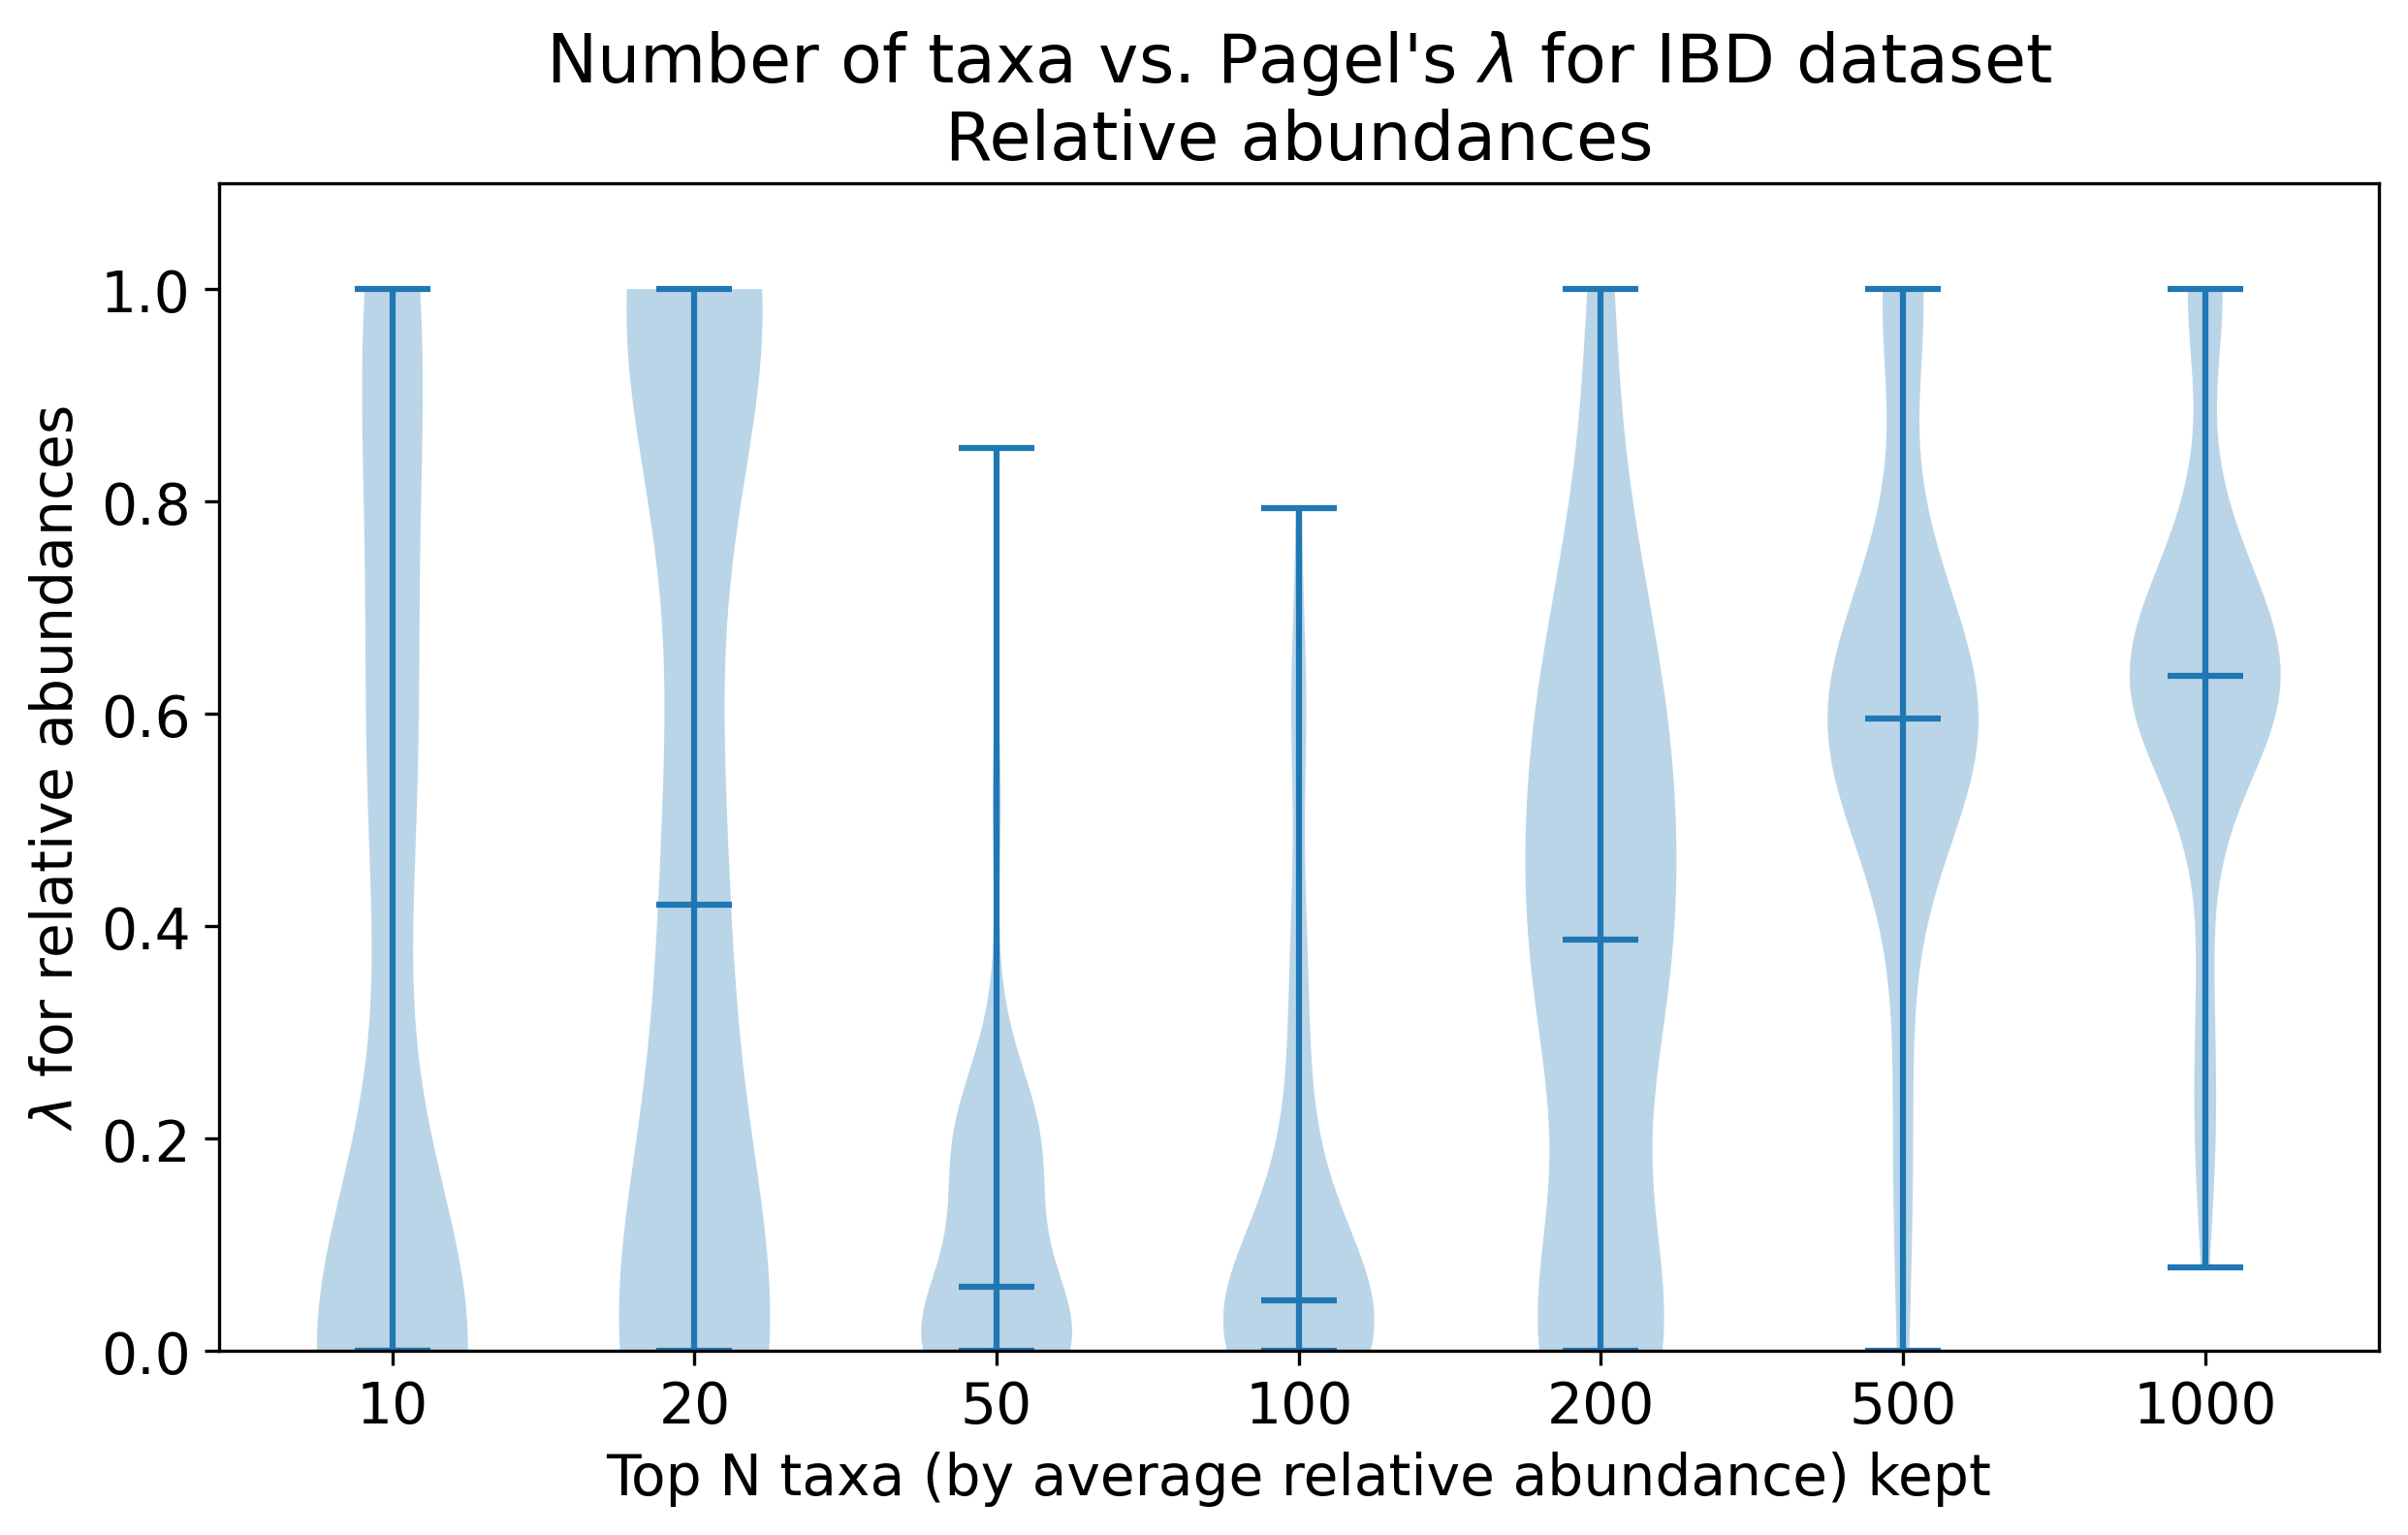

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = []
for top_n in topn_vals:
    pls = pd.read_table(f"./results/ibd_{ab_str}pls_top{top_n}.tsv")
    pls["top_n"] = top_n
    data.append(pls)

pls = pd.concat(data)

# Plot
plt.figure(**FIG)
# for i, top_n in enumerate(pls["top_n"].unique()):
plt.violinplot(
    [x["lambda"].values for x in data],
    showmedians=True,
    # positions=[i + 1],
)

# plt.xticks(range(1, len(topn_vals) + 1), topn_vals[:-1] + ["1370 (all)"])
plt.xticks(range(1, len(topn_vals) + 1), topn_vals)
plt.xlabel("Top N taxa (by average relative abundance) kept")
plt.ylabel(f"$\lambda$ for {ab_title.lower()}")
plt.title(f"Number of taxa vs. Pagel's $\lambda$ for IBD dataset\n{ab_title}")
plt.ylim(0, 1.1)
plt.savefig(f"./results/{ab_str}pls_top_n.png", dpi=300)
plt.show()

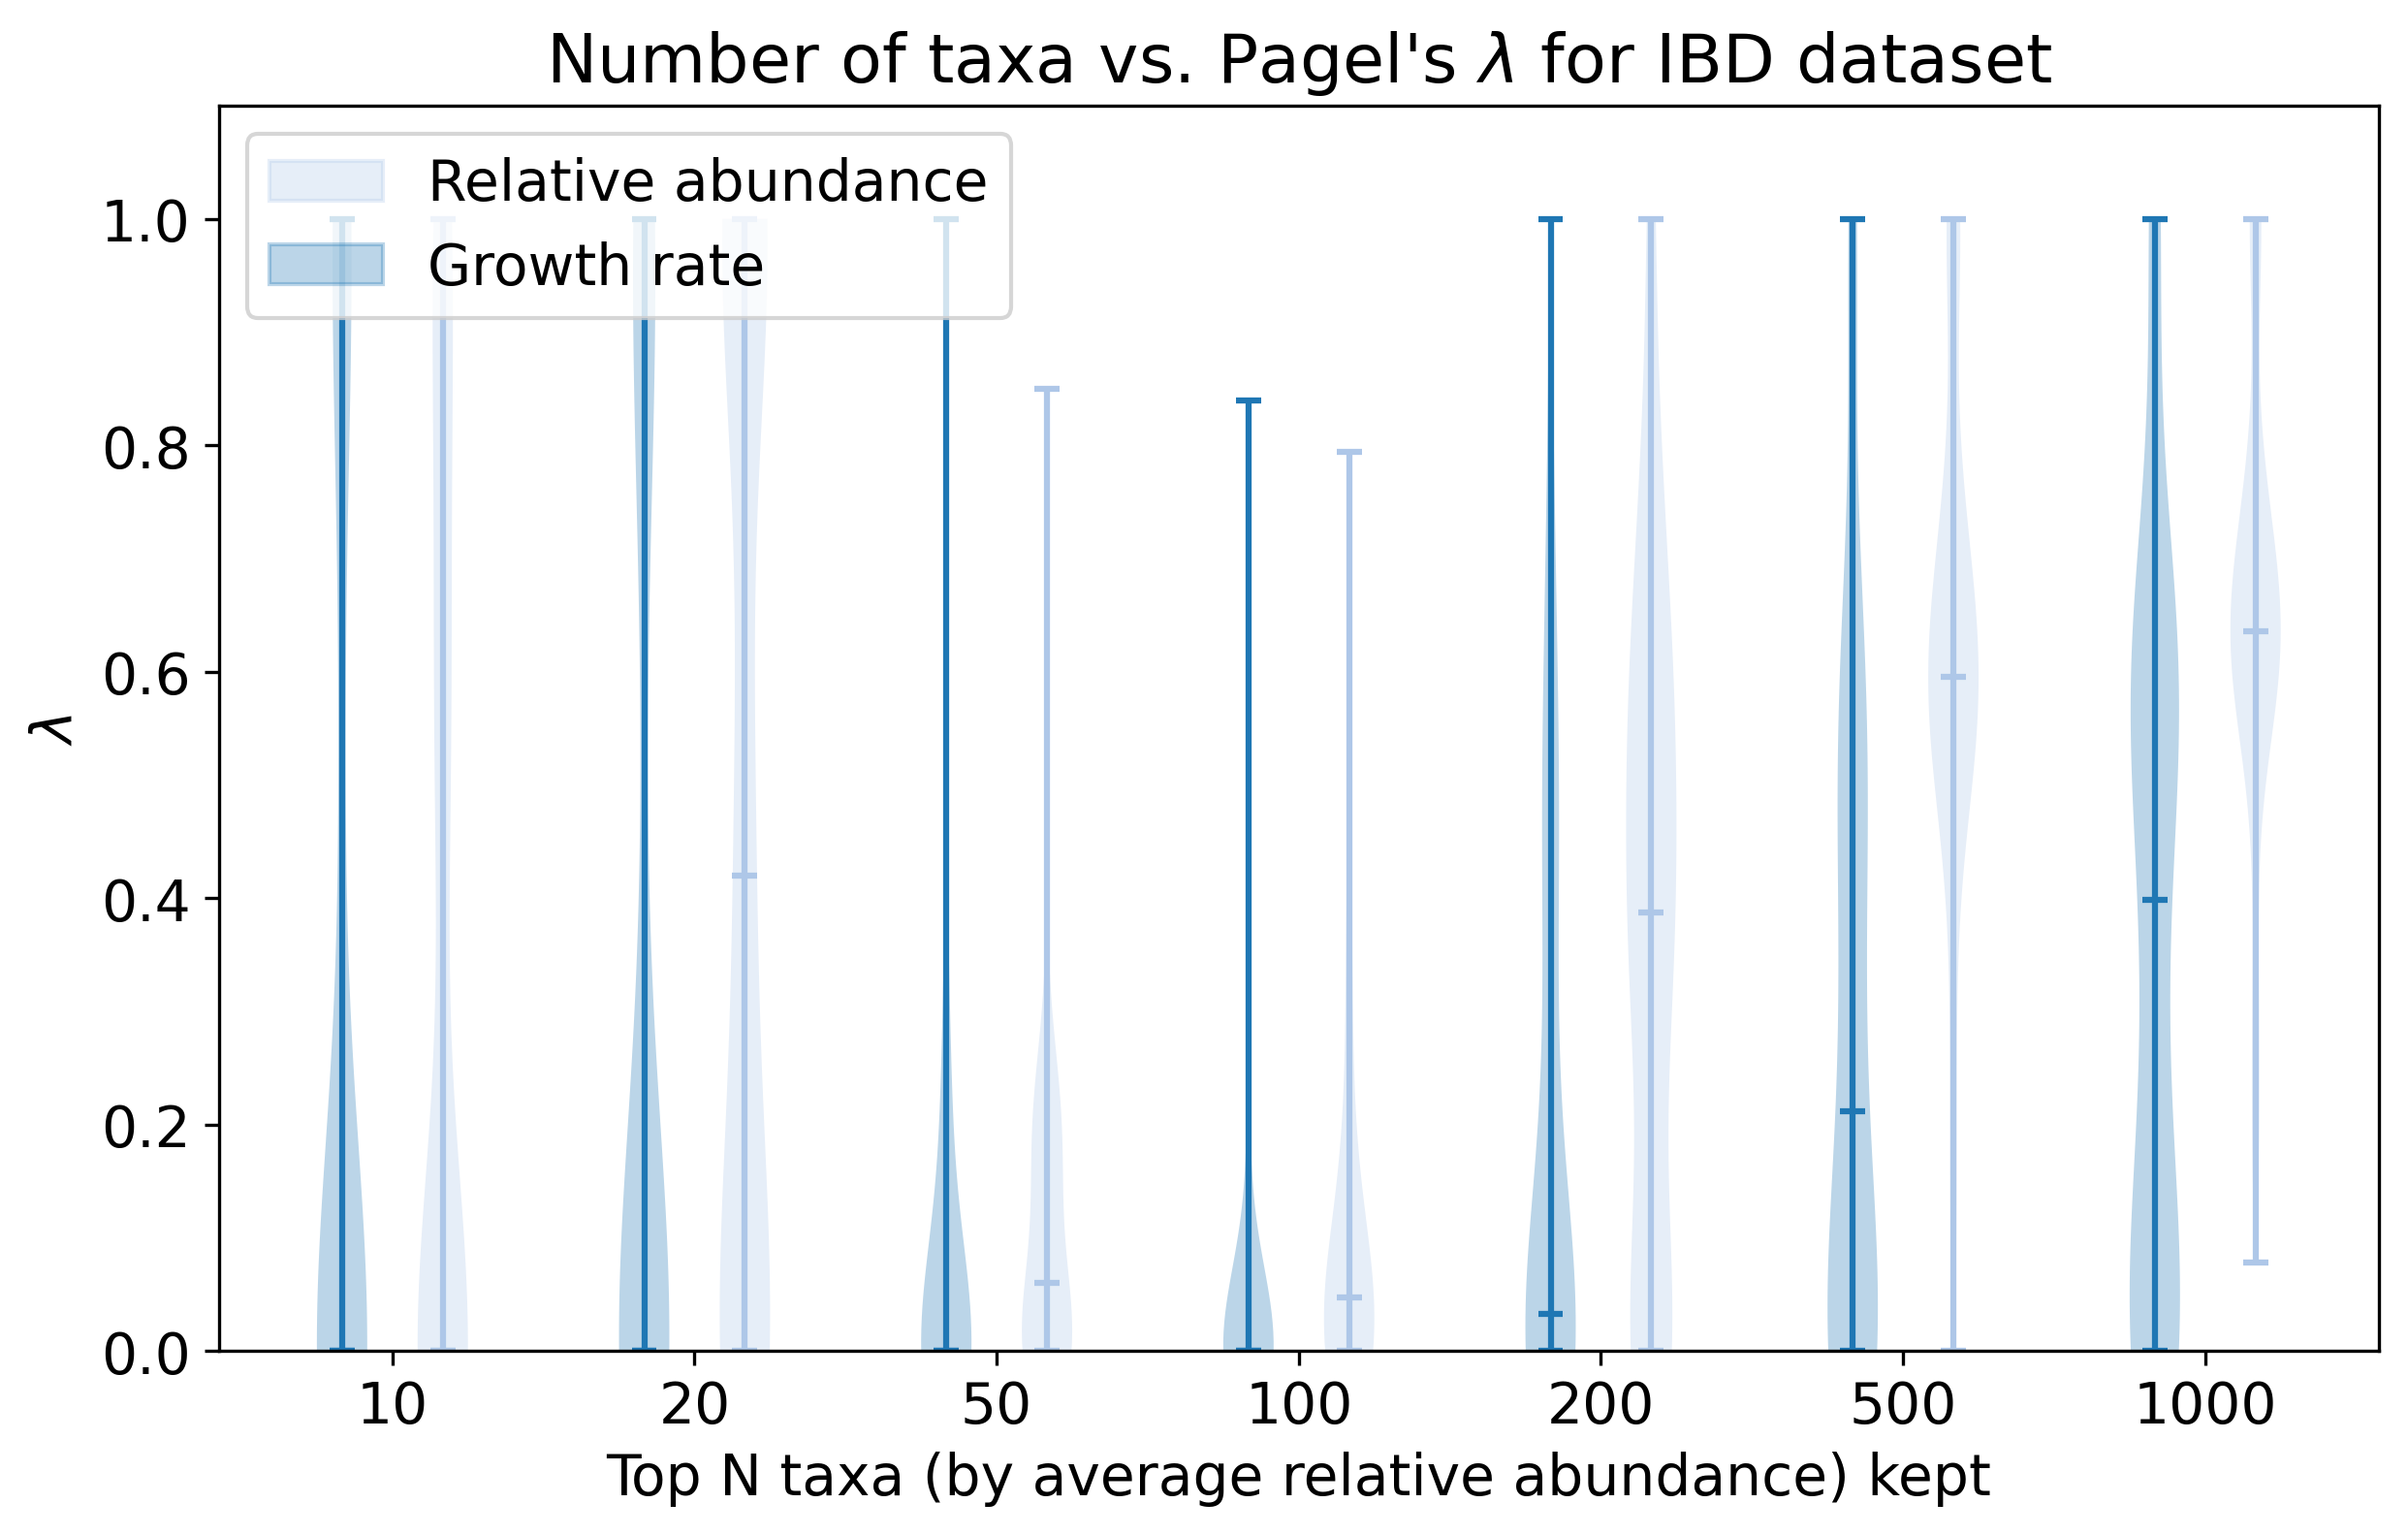

In [88]:
# Same thing, but plotting abundance and relative abundance side by side

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

labels = []
def add_label(violin, label):
    # Taken from stackoverflow
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((patches.Patch(color=color), label))

# Colors
cmap = matplotlib.cm.get_cmap("tab20", 20) # looks best with 20
dark_blue = cmap.colors[0]
light_blue = cmap.colors[1]

# Load data
plt.figure(**FIG)
lambdas = {}
for ABUNDANCE in [True, False]:
    if ABUNDANCE:
        ab_str = "abun_"
    else:
        ab_str = ""
    data = []
    for top_n in topn_vals:
        pls = pd.read_table(f"./results/ibd_{ab_str}pls_top{top_n}.tsv")
        pls["top_n"] = top_n
        data.append(pls)

    # Plot
    # for i, top_n in enumerate(pls["top_n"].unique()):
    positions = np.arange(len(data)) * 3 + 1
    if ABUNDANCE:
        positions += 1
        c = light_blue
    else:
        c = dark_blue
    ax = plt.violinplot(
        [x["lambda"].values for x in data],
        showmedians=True,
        positions=positions
    )

    # Set color
    for partname in ["cbars", "cmins", "cmaxes", "cmedians"]:
        ax[partname].set_edgecolor(c)
    # ax["bodies"][0].set_facecolor(c)
    for violin in ax["bodies"]:
       violin.set_facecolor(c) # it's actually a dict

    # Add label after setting color
    add_label(ax, f"Relative abundance" if ABUNDANCE else "Growth rate")

plt.xticks(positions + 0.5, topn_vals)
plt.xlabel("Top N taxa (by average relative abundance) kept")
plt.ylabel(f"$\lambda$")
plt.title(f"Number of taxa vs. Pagel's $\lambda$ for IBD dataset")
plt.ylim(0, 1.1)


plt.legend(*zip(*labels), loc=2)
plt.savefig(f"./results/both_pls_top_n.png", dpi=300)
plt.show()